## Deep Learning Approach for Anthracnose Disease Detection in Chilli Plants

### Author: Vishnu Vardhan Reddy Alla

Anthracnose disease poses a significant threat to chili plant health, impacting yield and quality. Traditional methods of disease detection often rely on visual inspection. In this project, we leverage deep learning techniques to develop a model for identifying Anthracnose disease in chili plants. By fine-tuning a pre-trained ResNet50 model, originally trained on ImageNet, we aim to enhance its capability to accurately classify plant images as either affected or unaffected by Anthracnose. This approach not only streamlines the detection process but also holds promise for early intervention and improved agricultural management practices.


Importing all the required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Creating a transform to use the images from the dataset in the model. The mean and standard deviation values for resnet50 model are available in the google.

In [3]:
data_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Creating the datasets and loading them into the Dataloader.

In [4]:
test_dir = "C:/Users/VISHNU/OneDrive/Documents/GitHub/Anthracnose-Disease-in-Chilli-Plant-Detection/Anthracnose_in_chilli_Mobile_captured/test"
train_dir = "C:/Users/VISHNU/OneDrive/Documents/GitHub/Anthracnose-Disease-in-Chilli-Plant-Detection/Anthracnose_in_chilli_Mobile_captured/train"
val_dir = "C:/Users/VISHNU/OneDrive/Documents/GitHub/Anthracnose-Disease-in-Chilli-Plant-Detection/Anthracnose_in_chilli_Mobile_captured/validation"

test_dataset = datasets.ImageFolder(test_dir, transform = data_transform)
train_dataset = datasets.ImageFolder(train_dir, transform = data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform = data_transform)

batch_size = 4

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

Initializing a pre-trained ResNet-50 model

In [5]:
resnet = torchvision.models.resnet50(pretrained = True)

C:\Users\VISHNU\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\VISHNU\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
resnet.to(device);

Creating a function to evaluate the test data using a given model. The function creates a confusion matrix as well as a stacked bar plot.

In [7]:
def get_class_names(index):
    if index < len(test_dataset.classes):
        return test_dataset.classes[index]
    else:
        return "Unknown Class"


def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    Predicted = []
    Ground_Truth = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(predicted)):
              Predicted.append(get_class_names(predicted[i]))
              Ground_Truth.append(get_class_names(labels[i]))
    print('Accuracy on test images: {:.2f}%'.format(100 * correct / total))
    prediction_df = pd.DataFrame({'Predicted':Predicted, 'Ground Truth':Ground_Truth})
    conf_matrix = confusion_matrix(prediction_df['Ground Truth'], prediction_df['Predicted'])

    plt.figure(figsize=(8, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    stacked_df = pd.crosstab(prediction_df['Predicted'], prediction_df['Ground Truth'])
    stacked_df.plot(kind='bar', stacked=True, figsize=(8, 4), cmap = 'Paired', width = 0.3, edgecolor = 'black')
    plt.title('Stacked Bar Plot of Predictions and Ground Truths')
    plt.xlabel('Ground Truths')
    plt.ylabel('Count')
    plt.show()


Freezing the entine network and modifying the last layer of the model as per our dataset.

In [9]:
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, len(train_dataset.classes))

num_classes = len(test_dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)


Creating a function to train the model and training the resnot model. The function plots both the loss and accuracy curves for both training and validation sets.

Epoch 1/5, Loss: 0.5532, Accuracy: 0.7627
Validation Accuracy: 0.9400
Epoch 2/5, Loss: 0.3660, Accuracy: 0.8333
Validation Accuracy: 0.9400
Epoch 3/5, Loss: 0.3187, Accuracy: 0.8785
Validation Accuracy: 0.9600
Epoch 4/5, Loss: 0.3017, Accuracy: 0.8588
Validation Accuracy: 0.9400
Epoch 5/5, Loss: 0.2322, Accuracy: 0.9096
Validation Accuracy: 0.9600


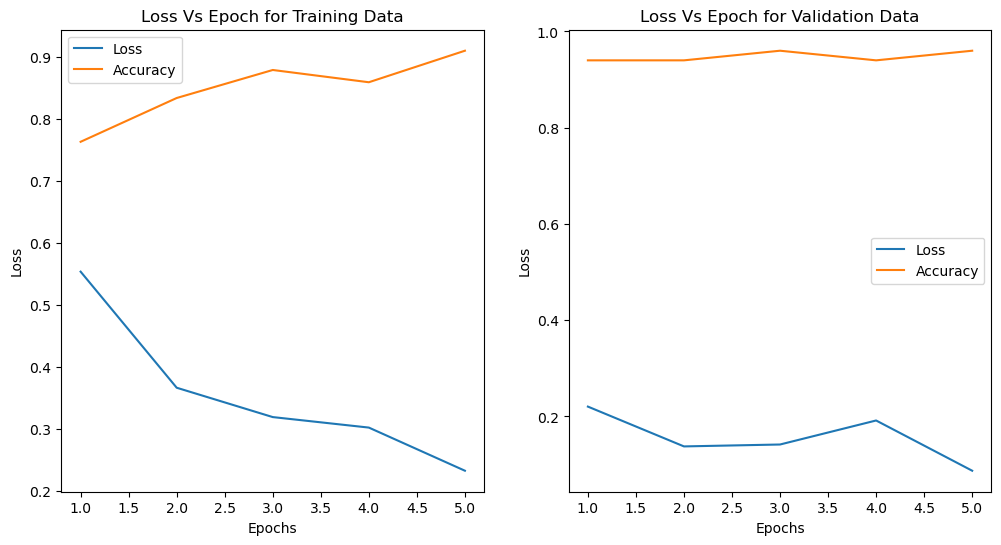

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Evaluate on validation set
        model.eval()
        val_correct = 0
        val_total = 0
        running_vloss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                optimizer.zero_grad()
                val_outputs = model(val_inputs)
                vloss = criterion(val_outputs, val_labels)
                running_vloss += vloss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        val_acc = val_correct / val_total
        val_loss = running_vloss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(range(1,6), train_losses, label = 'Loss')
    plt.plot(range(1,6), train_accuracy, label = 'Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Vs Epoch for Training Data")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1,6), val_losses, label = 'Loss')
    plt.plot(range(1,6), val_accuracy, label = 'Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Vs Epoch for Validation Data")
    plt.legend()

# Train the model
train_model(resnet, criterion, optimizer, train_loader, val_loader, num_epochs=5)


Evaluating the entire testset using the trained model.

Accuracy on test images: 97.09%


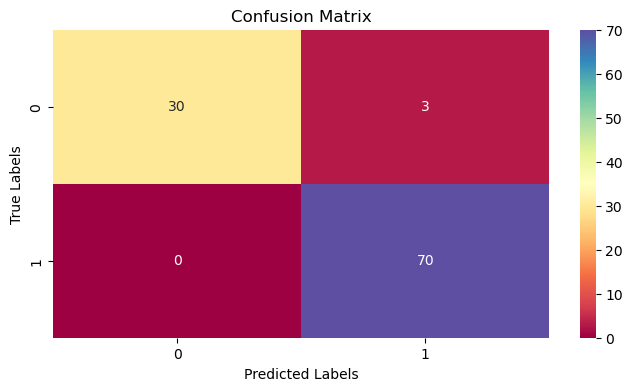

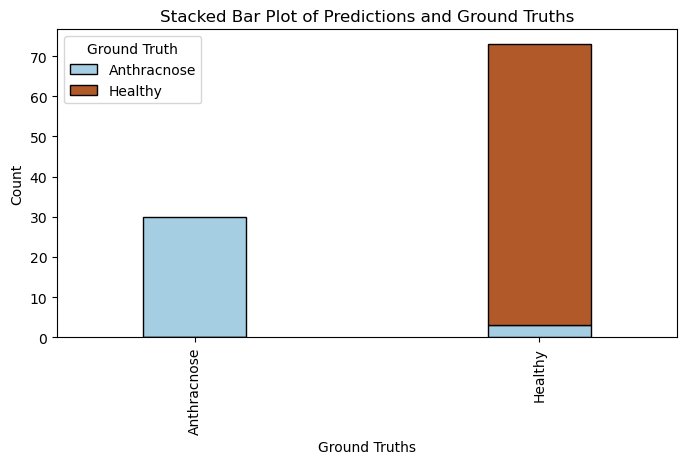

In [11]:
evaluate_model(resnet, test_loader)

Ater trainig the model, the model was able to identify most of the images from testing set correctly. The model was able to produce results with an accuracy of 97%.

The Confusion matrix and stacked bar plot are plotted for the results.

An accuracy of 100% is desirable,but we must consider factors such as overfitting, data bias, etc. The model might has learned to memorize the training data instead of generalizing patterns. Another possibility could be that the test dataset might be similar to the training dataset, leading to biased evaluation.

This above possibilities can be eleminated by making the model robust. It involves training the model with an unbiased dataset and augmented data could be useful.

Creating a transform to apply augmentation to the training data.

Have used RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation augmentations.

In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Creating the dataset and dataLoader for the augmented training data.

In [13]:
train_aug = datasets.ImageFolder(train_dir, transform=train_transform)

train_augload = torch.utils.data.DataLoader(train_aug, batch_size = 4, shuffle=True)

Displaying augmented images from the training dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


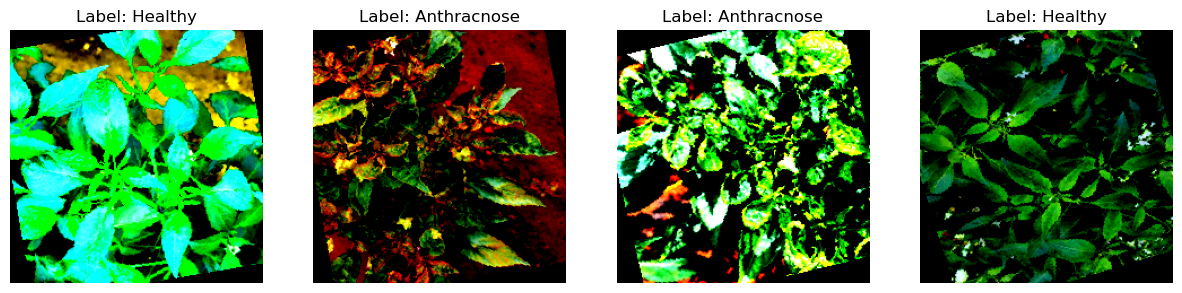

In [14]:
def display_augmented_images(dataset, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[index]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"Label: {test_dataset.classes[label]}")
        axes[i].axis('off')
    plt.show()

display_augmented_images(train_aug, 4)

Training the resnet model using augmented training dataset.

Epoch 1/5, Loss: 0.4739, Accuracy: 0.8051
Validation Accuracy: 0.9200
Epoch 2/5, Loss: 0.3233, Accuracy: 0.8446
Validation Accuracy: 0.9200
Epoch 3/5, Loss: 0.3468, Accuracy: 0.8418
Validation Accuracy: 0.9600
Epoch 4/5, Loss: 0.4181, Accuracy: 0.8277
Validation Accuracy: 0.9400
Epoch 5/5, Loss: 0.3767, Accuracy: 0.8390
Validation Accuracy: 0.9600
Accuracy on test images: 96.12%


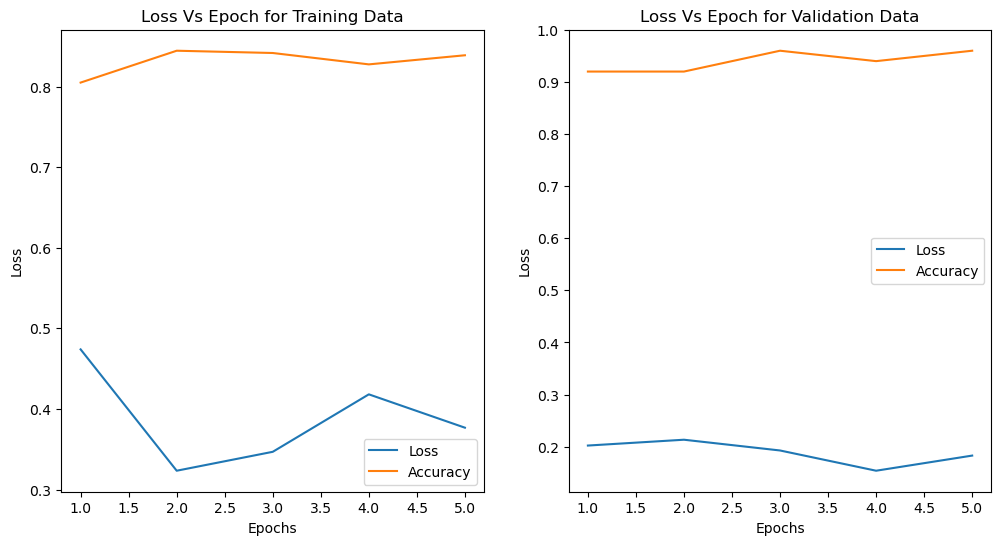

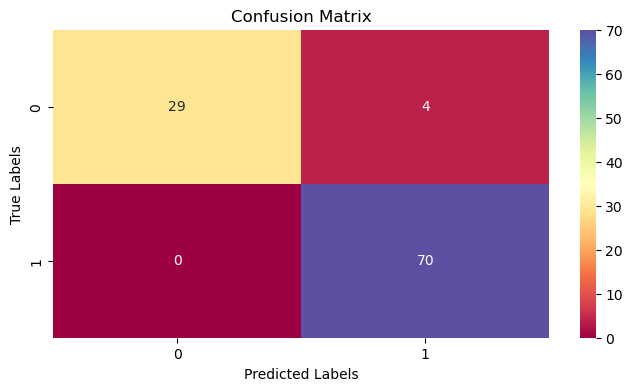

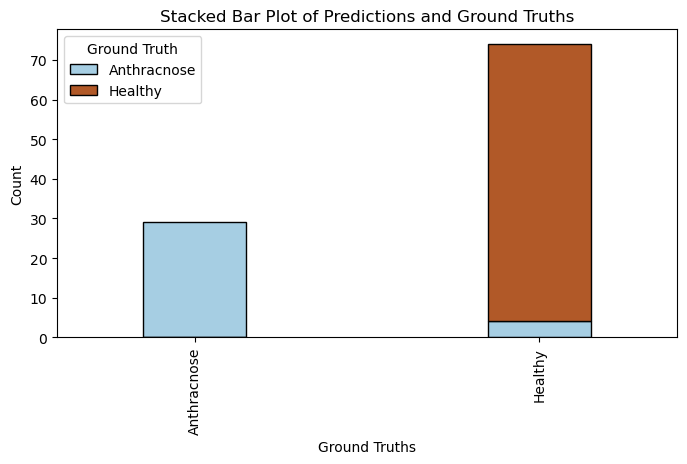

In [15]:
train_model(resnet, criterion, optimizer, train_augload, val_loader, num_epochs=5)

evaluate_model(resnet, test_loader)

I model was trained with augmented data and the model gave an accuracy of 96%. The overall accuracy of the model have decreased.

This could be because the overfitting and bias problems were elemenated with using augmented data and it improves the robustness of the model.